<a href="https://colab.research.google.com/github/harikishantk/Breast-Cancer-Classification-with-Autoencoder-Point5RBM-Method/blob/main/RBM_AE_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid

from torchvision.datasets import MNIST, ImageFolder

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
test_path = "/content/drive/MyDrive/output/test"
train_path = "/content/drive/MyDrive/output/train"
val_path = "/content/drive/MyDrive/output/val"
saved_models_path = "/content/drive/MyDrive/saved models"

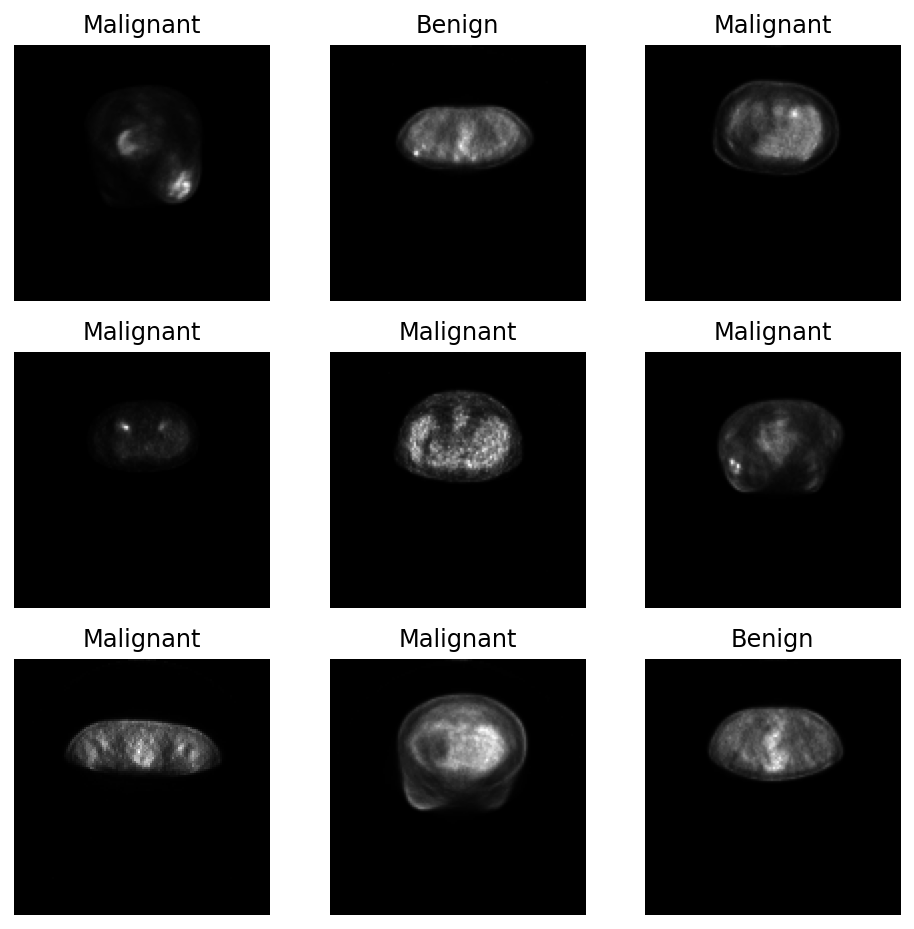

In [43]:
labels_map = {
    0: "Benign",
    1: "Malignant",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[0].squeeze(), cmap="gray")
plt.show()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data_path = "/content/drive/MyDrive/output/"
test_path = "/content/drive/MyDrive/output/test"
train_path = "/content/drive/MyDrive/output/train"
val_path = "/content/drive/MyDrive/output/val"
saved_models_path = "/content/drive/MyDrive/saved models"

In [6]:
data_transforms = transforms.Compose([
                   transforms.Grayscale(num_output_channels=1),
                   transforms.ToTensor(), 
                    transforms.Lambda(lambda x: torch.flatten(x))
                    ])

image_datasets = {'train': datasets.ImageFolder(train_path,data_transforms),
                  'valid': datasets.ImageFolder(val_path,data_transforms),
                  'test': datasets.ImageFolder(test_path,data_transforms)}       

batch_size = 15
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid','test']}
class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes        

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:
class RBM(torch.nn.Module):
    def __init__(self, visible_dim, hidden_dim, gaussian_hidden_distribution=False):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.gaussian_hidden_distribution = gaussian_hidden_distribution

        # intialize parameters
        self.W = torch.randn(visible_dim, hidden_dim) * 0.1
        self.h_bias = torch.zeros(hidden_dim)   # visible --> hidden
        self.v_bias = torch.zeros(visible_dim)  # hidden --> visible

        # parameters for learning with momentum
        self.W_momentum = torch.zeros(visible_dim, hidden_dim)
        self.h_bias_momentum = torch.zeros(hidden_dim)
        self.v_bias_momentum = torch.zeros(visible_dim)

    def sample_h(self, v):
        """Get sample hidden values and activation probabilities"""
        activation = torch.mm(v, self.W) + self.h_bias
        if self.gaussian_hidden_distribution:
            return activation, torch.normal(activation, torch.tensor([1]))
        else:
            p = torch.sigmoid(activation)
            return p, torch.bernoulli(p)

    def sample_v(self, h):
        """Get visible activation probabilities"""
        activation = torch.mm(h, self.W.t()) + self.v_bias
        p = torch.sigmoid(activation)
        return p
    
    def update_weights(self, v0, vk, ph0, phk, lr, 
                       momentum_coef, weight_decay, batch_size):
        """Learning step: update parameters"""
        self.W_momentum *= momentum_coef
        self.W_momentum += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)

        self.h_bias_momentum *= momentum_coef
        self.h_bias_momentum += torch.sum((ph0 - phk), 0)

        self.v_bias_momentum *= momentum_coef
        self.v_bias_momentum += torch.sum((v0 - vk), 0)

        self.W += lr*self.W_momentum/batch_size
        self.h_bias += lr*self.h_bias_momentum/batch_size
        self.v_bias += lr*self.v_bias_momentum/batch_size

        self.W -= self.W * weight_decay # L2 weight decay

In [17]:
def train_rbm(train_dl, visible_dim, hidden_dim, k, num_epochs, lr, use_gaussian=False):
    """Create and train an RBM
    
    Uses a custom strategy to have 0.5 momentum before epoch 5 and 0.9 momentum after
    
    Parameters
    ----------
    train_dl: DataLoader
        training data loader
    visible_dim: int
        number of dimensions in visible (input) layer
    hidden_dim: int
        number of dimensions in hidden layer
    k: int
        number of iterations to run for Gibbs sampling (often 1 is used)
    num_epochs: int
        number of epochs to run for
    lr: float
        learning rate
    use_gaussian:
        whether to use a Gaussian distribution for the hidden state
    
    Returns
    -------
    RBM, Tensor, Tensor
        a trained RBM model, sample input tensor, reconstructed activation probabilities for sample input tensor

    """
    rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim, gaussian_hidden_distribution=use_gaussian)
    loss = torch.nn.MSELoss() # we will use MSE loss

    for epoch in range(num_epochs):
        train_loss = 0
        for i, data_list in enumerate(train_dl):
            sample_data = data_list[0]
            v0, pvk = sample_data, sample_data
            
            # Gibbs sampling
            for i in range(k):
                _, hk = rbm.sample_h(pvk)
                pvk = rbm.sample_v(hk)
            
            # compute ph0 and phk for updating weights
            ph0, _ = rbm.sample_h(v0)
            phk, _ = rbm.sample_h(pvk)
            
            # update weights
            rbm.update_weights(v0, pvk, ph0, phk, lr, 
                               momentum_coef=0.5 if epoch < 5 else 0.9, 
                               weight_decay=2e-4, 
                               batch_size=sample_data.shape[0])

            # track loss
            train_loss += loss(v0, pvk)
        
        # print training loss
        print(f"epoch {epoch}: {train_loss/len(train_dl)}")
        
        torch.save({
        'model': rbm,
        'W': rbm.W,
        'h_bias': rbm.h_bias,
        'v_bias': rbm.v_bias,
        'loss': loss
        }, saved_models_path + f"/rbm-{visible_dim}-{hidden_dim}.tar")

    return rbm, v0, pvk

In [152]:
print(rbm1W.shape)

torch.Size([16384, 1000])


In [154]:
hidden_dimensions = [
    {
        "visible_dim": 16384,
        "hidden_dim": 1000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 28, 
        "display_dim2": 28, 
        "use_gaussian": False
    }, 
    {
        "visible_dim": 1000,
        "hidden_dim": 750, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "visible_dim": 750,
        "hidden_dim": 250, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "visible_dim": 250,
        "hidden_dim": 50, 
        "num_epochs": 30, 
        "learning_rate": 0.001, # use much lower LR for gaussian to avoid exploding gradient
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True # use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
    }
]

In [100]:
# get initial iteration of new training dl
new_train_dl = dataloaders['train']
visible_dim = 16384
hidden_dim = None
models = [] # trained RBM models
for configs in hidden_dimensions:
    
    # parse configs
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]
    
    # train RBM
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_rbm(new_train_dl, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    
    # display sample output
    # display_output(v, v_pred, d1, d2)

    # rederive new data loader based on hidden activations of trained model
    new_data = []
    for data_list in new_train_dl:
        p = model.sample_h(data_list[0])[0]
        new_data.append(p)
    new_input = np.concatenate(new_data)
    new_train_dl = DataLoader(
        TensorDataset(torch.Tensor(new_input)), 
        batch_size=15, 
        shuffle=False
    )
    
    # update new visible_dim for next RBM
    visible_dim = hidden_dim

16384 to 1000
epoch 0: 0.007888258434832096
epoch 1: 0.001705835689790547
epoch 2: 0.0012724820990115404
epoch 3: 0.0011119712144136429
epoch 4: 0.0010290408972650766
epoch 5: 0.0016684281872585416
epoch 6: 0.0016272998182103038
epoch 7: 0.0015262702945619822
epoch 8: 0.0015109156956896186
epoch 9: 0.0014839647337794304
1000 to 750
epoch 0: 0.004894232843071222
epoch 1: 0.0022855419665575027
epoch 2: 0.0019435322610661387
epoch 3: 0.0017897598445415497
epoch 4: 0.0016995553160086274
epoch 5: 0.002573627745732665
epoch 6: 0.0021467478945851326
epoch 7: 0.0019326101755723357
epoch 8: 0.001837019925005734
epoch 9: 0.0017791464924812317
750 to 250
epoch 0: 0.009709971025586128
epoch 1: 0.00450262101367116
epoch 2: 0.0037997206673026085
epoch 3: 0.003443921683356166
epoch 4: 0.003232137765735388
epoch 5: 0.004153575282543898
epoch 6: 0.0034793061204254627
epoch 7: 0.003099625464528799
epoch 8: 0.0028760621789842844
epoch 9: 0.0027390941977500916
250 to 50
epoch 0: 0.07310012727975845
epoch 

In [155]:
# if not models:
#   print("not exists")
  
# else:
#   print("its there")
rbm1 = RBM(16384,1000)
checkpoint = torch.load(saved_models_path + f"/rbm-16384-1000.tar")

rbm1W = checkpoint['model'].W
models_load = []
for configs in hidden_dimensions:
    
    # parse configs
    visible_dim = configs["visible_dim"]
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]

    model = torch.load(saved_models_path + f"/rbm-{visible_dim}-{hidden_dim}.tar")
    model = model['model']
    models_load.append(model)

In [134]:
class DAE(nn.Module):
    """A Deep Autoencoder that takes a list of RBMs as input"""

    def __init__(self, models):
        """Create a deep autoencoder based on a list of RBM models

        Parameters
        ----------
        models: list[RBM]
            a list of RBM models to use for autoencoding
        """
        super(DAE, self).__init__()

        # extract weights from each model
        # encoders = []
        # encoder_biases = []
        # build encoders and decoders based on weights from each 
        self.encoders = nn.ParameterList([nn.Parameter(model.W.clone()) for model in models])
        self.encoder_biases = nn.ParameterList([nn.Parameter(model.h_bias.clone()) for model in models])
        self.decoders = nn.ParameterList([nn.Parameter(model.W.clone()) for model in reversed(models)])
        self.decoder_biases = nn.ParameterList([nn.Parameter(model.v_bias.clone()) for model in reversed(models)])
        
        self.encoder = torch.nn.Sequential(
			torch.nn.Linear(16384, 1000),
			torch.nn.BatchNorm1d(1000),
			torch.nn.ReLU(),
			torch.nn.Linear(1000, 750),
			torch.nn.BatchNorm1d(750),
			torch.nn.ReLU(),
			torch.nn.Linear(750, 250),
			torch.nn.BatchNorm1d(250),
			torch.nn.ReLU(),
      torch.nn.Linear(250, 50),
			torch.nn.BatchNorm1d(50),
			torch.nn.ReLU(),
		)
        self.decoder = torch.nn.Sequential(
      torch.nn.Linear(50, 250),
			torch.nn.BatchNorm1d(250),
			torch.nn.ReLU(),
			torch.nn.Linear(250, 750),
			torch.nn.BatchNorm1d(750),
			torch.nn.ReLU(),
			torch.nn.Linear(750, 1000),
			torch.nn.BatchNorm1d(1000),
			torch.nn.ReLU(),
			torch.nn.Linear(1000, 16384)
		)
        self.classifier = torch.nn.Sequential(
			torch.nn.Linear(16384,1000),
			torch.nn.BatchNorm1d(1000),
			torch.nn.ReLU(),
			torch.nn.Linear(1000,1),
	 		torch.nn.Sigmoid()
		)
        

    def forward(self, v):
        """Forward step

        Parameters
        ----------
        v: Tensor
            input tensor

        Returns
        -------
        Tensor
            a reconstruction of v from the autoencoder

        """
        # encode
        p_h = self.encoder(v)



        # decode
        p_v = self.decode(p_h)


        out = self.classifier(p_v)

        return out


    def encode(self, v):  # for visualization, encode without sigmoid
        """Encode input

        Parameters
        ----------
        v: Tensor
            visible input tensor

        Returns
        -------
        Tensor
            the activations of the last layer

        """
        p_v = v
        activation = v
        for i in range(len(self.encoders)):
            W = self.encoders[i]
            h_bias = self.encoder_biases[i]
            activation = torch.mm(p_v, W) + h_bias
            p_v = torch.relu(activation)

        # for the last layer, we want to return the activation directly rather than the sigmoid
        return p_v

    def decode(self, h):
        """Encode hidden layer

        Parameters
        ----------
        h: Tensor
            activations from last hidden layer

        Returns
        -------
        Tensor
            reconstruction of original input based on h

        """
        p_h = h
        for i in range(len(self.encoders)):
            W = self.decoders[i]
            v_bias = self.decoder_biases[i]
            activation = torch.mm(p_h, W.t()) + v_bias
            p_h = torch.relu(activation)
        return p_h

In [128]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    threshold = torch.tensor([0.5])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                # print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs)
                    preds = (outputs>threshold).float()*1
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            
            if phase == 'valid':
                scheduler.step(loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [135]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Model Initialization
dae = DAE(models).to(device)

# Validation using MSE Loss function
criterion = torch.nn.BCELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(dae.parameters(),
							lr = 1e-5,
							weight_decay = 1e-1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 2, verbose=2)
dae = train_model(dae, criterion, optimizer, scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5538 Acc: 0.7206
valid Loss: 0.3886 Acc: 0.8558

Epoch 1/4
----------
train Loss: 0.3571 Acc: 0.8525
valid Loss: 0.2778 Acc: 0.8860

Epoch 2/4
----------
train Loss: 0.2887 Acc: 0.8845
valid Loss: 0.2406 Acc: 0.9122

Epoch 3/4
----------
train Loss: 0.2404 Acc: 0.9067
valid Loss: 0.1506 Acc: 0.9489

Epoch 4/4
----------
train Loss: 0.2140 Acc: 0.9192
valid Loss: 0.1369 Acc: 0.9594

Training complete in 38m 44s
Best val Acc: 0.959371


In [136]:
torch.save(dae.state_dict(), saved_models_path + "/autoencoder_with_rbm_pre_trained_decode.pt")

In [ ]:
model_ft = dae()
model_ft.load_state_dict(torch.load(saved_models_path + "/autoencoder_with_rbm.pt"))
model_ft.eval()

In [137]:
dae.eval()  # it-disables-dropout
threshold = torch.tensor([0.5])
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)
        y_true.extend(labels)
        outputs = dae(images)
        y_pred.extend(outputs)
        preds = (outputs>threshold).float()*1
        correct += torch.sum(preds == labels.data)
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / dataset_sizes['test']))

Test Accuracy of the model: 971.8954467773438 %


In [88]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 3.5 MB/s 


In [138]:
from torchmetrics import ConfusionMatrix
target = torch.tensor(y_true)
preds = torch.tensor(y_pred)
confmat = ConfusionMatrix(num_classes=2)
confmat(preds, target)

tensor([[173,  35],
        [  7, 550]])

In [140]:
TP = 173
FP = 35
FN = 7
TN = 550
accuracy = (TP+TN)/(TP+TN+FP+FN)
misclassification = 1 - accuracy
precision = TP/(TP+FP)
try:
  sensitivity = TP/(TP+FN)
except:
  sensitivity = 0
specificity = (TN/TN+FP)
print("accuracy:", accuracy)
print("misclassification:", misclassification)
print("precision:", precision)
print("sensitivity:", sensitivity)
print("specificity:", specificity)

accuracy: 0.9450980392156862
misclassification: 0.05490196078431375
precision: 0.8317307692307693
sensitivity: 0.9611111111111111
specificity: 36.0


In [141]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(dae)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|      encoders.0     |  16384000  |
|      encoders.1     |   750000   |
|      encoders.2     |   187500   |
|      encoders.3     |   12500    |
|   encoder_biases.0  |    1000    |
|   encoder_biases.1  |    750     |
|   encoder_biases.2  |    250     |
|   encoder_biases.3  |     50     |
|      decoders.0     |   12500    |
|      decoders.1     |   187500   |
|      decoders.2     |   750000   |
|      decoders.3     |  16384000  |
|   decoder_biases.0  |    250     |
|   decoder_biases.1  |    750     |
|   decoder_biases.2  |    1000    |
|   decoder_biases.3  |   16384    |
|   encoder.0.weight  |  16384000  |
|    encoder.0.bias   |    1000    |
|   encoder.1.weight  |    1000    |
|    encoder.1.bias   |    1000    |
|   encoder.3.weight  |   750000   |
|    encoder.3.bias   |    750     |
|   encoder.4.weight  |    750     |
|    encoder.4.bias   |    750     |
|

85772969